In [1]:
!pip install -q kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download tusharpadhy/deepfake-dataset

Dataset URL: https://www.kaggle.com/datasets/tusharpadhy/deepfake-dataset
License(s): CC0-1.0
100% 5.42G/5.42G [04:24<00:00, 19.6MB/s]
100% 5.42G/5.42G [04:24<00:00, 22.0MB/s]


In [3]:
!unzip /content/deepfake-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Real/real_5499.jpg  
  inflating: valid/Real/real_55.jpg  
  inflating: valid/Real/real_550.jpg  
  inflating: valid/Real/real_5500.jpg  
  inflating: valid/Real/real_5501.jpg  
  inflating: valid/Real/real_5502.jpg  
  inflating: valid/Real/real_5503.jpg  
  inflating: valid/Real/real_5504.jpg  
  inflating: valid/Real/real_5505.jpg  
  inflating: valid/Real/real_5506.jpg  
  inflating: valid/Real/real_5507.jpg  
  inflating: valid/Real/real_5508.jpg  
  inflating: valid/Real/real_5509.jpg  
  inflating: valid/Real/real_551.jpg  
  inflating: valid/Real/real_5510.jpg  
  inflating: valid/Real/real_5511.jpg  
  inflating: valid/Real/real_5512.jpg  
  inflating: valid/Real/real_5513.jpg  
  inflating: valid/Real/real_5514.jpg  
  inflating: valid/Real/real_5515.jpg  
  inflating: valid/Real/real_5516.jpg  
  inflating: valid/Real/real_5517.jpg  
  inflating: valid/Real/real_5518.jpg  
  inflating: valid/Real/real_5519

In [4]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time, copy
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import timm

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='/content/train', transform=transform)
batch_size = 256
data_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

image, label = image_dataset[0]
print("Example Image Shape:", image.shape)
print("Example Label:", label)


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = '/content/train'
val_dir   = '/content/valid'
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

print("Classes found:", train_dataset.classes)


Example Image Shape: torch.Size([3, 224, 224])
Example Label: 0
Classes found: ['Fake', 'Real']


In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 240002
Number of validation samples: 59428


In [7]:
model = timm.create_model('efficientnet_b0', pretrained=True)

# Freeze all parameters.
for param in model.parameters():
    param.requires_grad = False

# Reset the classifier for binary classification.
# timm models usually implement get_classifier() and reset_classifier().
print("Original classifier:", model.get_classifier())
model.reset_classifier(num_classes=1)
print("Modified classifier:", model.get_classifier())

# Move the model to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Original classifier: Linear(in_features=1280, out_features=1000, bias=True)
Modified classifier: Linear(in_features=1280, out_features=1, bias=True)
EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1

In [8]:
criterion = nn.BCEWithLogitsLoss()

# Initially, optimize only the classifier parameters.
optimizer = optim.Adam(model.get_classifier().parameters(), lr=1e-4)

def train_model(model, criterion, optimizer, dataloaders, num_epochs=10, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = dataloaders['train']
            else:
                model.eval()
                loader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (torch.sigmoid(outputs) > 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += inputs.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    history = {'train_loss': train_losses, 'val_loss': val_losses,
               'train_acc': train_accs, 'val_acc': val_accs}
    return model, history

dataloaders = {'train': train_loader, 'val': val_loader}

In [9]:
num_epochs = 5  # Adjust as needed.
model, history = train_model(model, criterion, optimizer, dataloaders,
                             num_epochs=num_epochs, device=device)


Epoch 1/5
----------
Train Loss: 0.6078 Acc: 0.6688
Val Loss: 0.6050 Acc: 0.6783

Epoch 2/5
----------
Train Loss: 0.5731 Acc: 0.6993
Val Loss: 0.5897 Acc: 0.6894

Epoch 3/5
----------
Train Loss: 0.5623 Acc: 0.7067
Val Loss: 0.5890 Acc: 0.6896

Epoch 4/5
----------
Train Loss: 0.5558 Acc: 0.7121
Val Loss: 0.5860 Acc: 0.6924

Epoch 5/5
----------
Train Loss: 0.5521 Acc: 0.7133
Val Loss: 0.5800 Acc: 0.6958

Training complete in 20m 10s
Best val loss: 0.5800


In [10]:
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    elif "blocks" in name:
        try:
            block_num = int(name.split('.')[1])
            # For EfficientNet, adjust the threshold based on experimentation.
            if block_num >= 4:
                param.requires_grad = True
            else:
                param.requires_grad = False
        except Exception:
            param.requires_grad = False
    else:
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
num_epochs_ft = 5
model, history_ft = train_model(model, criterion, optimizer_ft, dataloaders,
                                num_epochs=num_epochs_ft, device=device)

history['train_loss'].extend(history_ft['train_loss'])
history['val_loss'].extend(history_ft['val_loss'])
history['train_acc'].extend(history_ft['train_acc'])
history['val_acc'].extend(history_ft['val_acc'])

Epoch 1/5
----------
Train Loss: 0.3423 Acc: 0.8421
Val Loss: 0.2335 Acc: 0.9012

Epoch 2/5
----------
Train Loss: 0.2260 Acc: 0.9034
Val Loss: 0.1728 Acc: 0.9287

Epoch 3/5
----------
Train Loss: 0.1880 Acc: 0.9214
Val Loss: 0.1346 Acc: 0.9464

Epoch 4/5
----------
Train Loss: 0.1655 Acc: 0.9313
Val Loss: 0.1401 Acc: 0.9447

Epoch 5/5
----------
Train Loss: 0.1504 Acc: 0.9382
Val Loss: 0.1051 Acc: 0.9588

Training complete in 26m 54s
Best val loss: 0.1051


In [11]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[28287  1354]
 [ 1094 28693]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.95      0.96     29641
        Real       0.95      0.96      0.96     29787

    accuracy                           0.96     59428
   macro avg       0.96      0.96      0.96     59428
weighted avg       0.96      0.96      0.96     59428



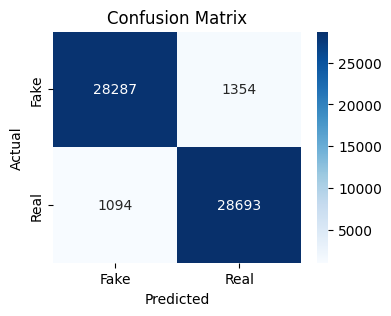

In [12]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

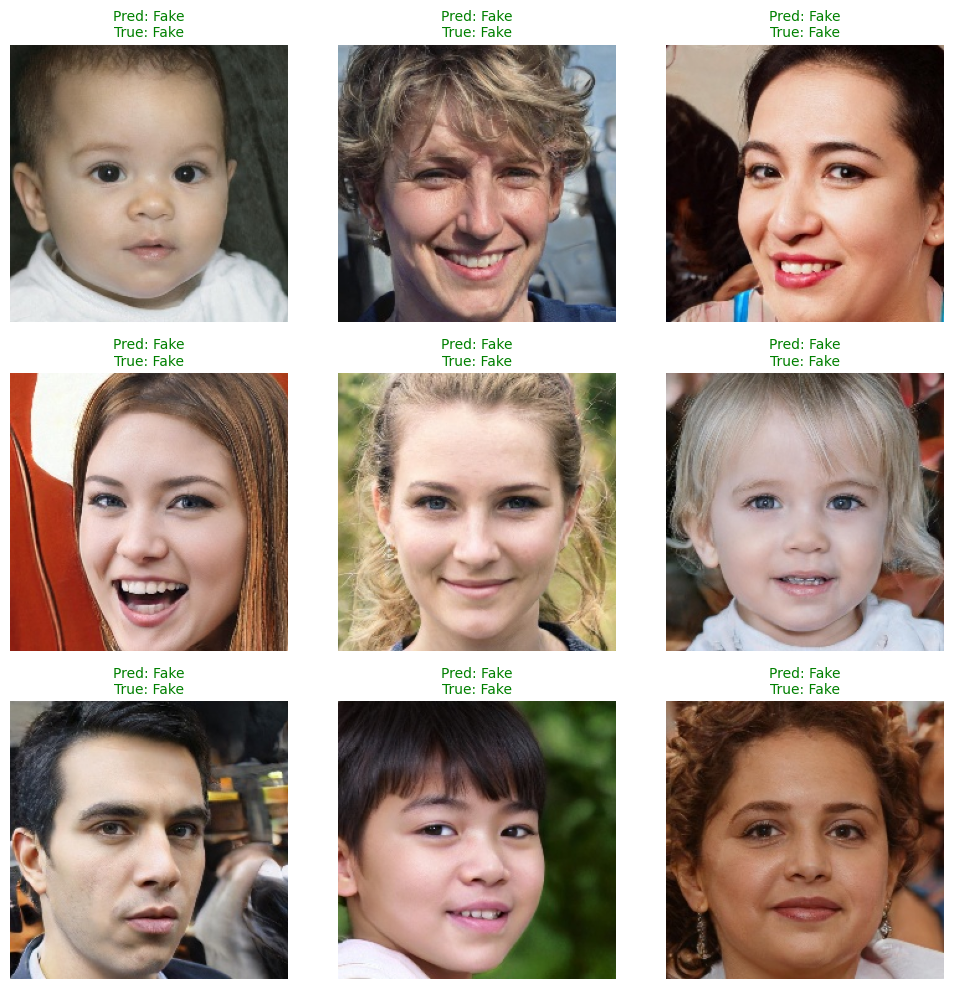

In [13]:
#Visualizing
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)
outputs = model(inputs)
preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy().flatten()
labels = labels.numpy()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    pred_label = train_dataset.classes[preds[i]]
    true_label = train_dataset.classes[labels[i]]
    color = "green" if pred_label == true_label else "red"
    imshow(inputs[i], title=f"Pred: {pred_label}\nTrue: {true_label}")
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
plt.tight_layout()
plt.show()


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

accuracy = accuracy_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds)  # Sensitivity is same as recall
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print(f"Accuracy: {accuracy*100:.1f}%")
print(f"Sensitivity (Recall): {recall*100:.1f}%")
print(f"Recall: {recall*100:.1f}%")
print(f"F1 Score: {f1*100:.1f}%")
print(f"AUC: {auc*100:.1f}%")

Accuracy: 95.9%
Sensitivity (Recall): 96.3%
Recall: 96.3%
F1 Score: 95.9%
AUC: 95.9%


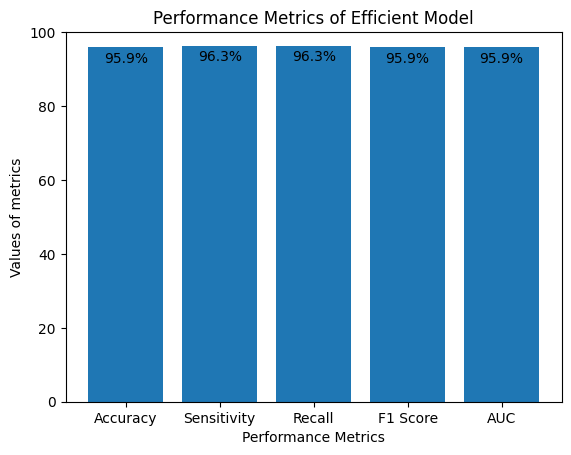

In [16]:
metrics_names = ['Accuracy', 'Sensitivity', 'Recall', 'F1 Score', 'AUC']
metrics_values = [accuracy*100, recall*100, recall*100, f1*100, auc*100]

fig, ax = plt.subplots()
bars = ax.bar(metrics_names, metrics_values)

# Add data labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval - 5, f'{yval:.1f}%', ha='center', va='bottom', color='black', fontsize=10)

# Plot formatting
plt.ylim(0, 100)
plt.ylabel('Values of metrics')
plt.xlabel('Performance Metrics')
plt.title('Performance Metrics of Efficient Model')
plt.show()